<a href="https://colab.research.google.com/github/Nada-Elghaweet/Ai-safety-system/blob/KNN/KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [52]:
import os
import numpy as np
import librosa
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [53]:
SAMPLE_RATE = 16000
N_MFCC = 40
SEGMENT_DURATION = 2.0
AUGMENT_TIMES = 2

violent_path = "/content/drive/MyDrive/violence/violent_audio_preprocessed"
non_violent_path = "/content/drive/MyDrive/non_violence/non_violent_audio_preprocessed"

In [54]:
def split_audio(audio, sr=SAMPLE_RATE, segment_duration=SEGMENT_DURATION):
    segment_length = int(segment_duration * sr)
    segments = []
    for start in range(0, len(audio), segment_length):
        segment = audio[start:start + segment_length]
        if len(segment) < 64:
            continue
        segments.append(segment)
    return segments

In [55]:
def extract_mfcc(audio, sr=SAMPLE_RATE, n_mfcc=N_MFCC):
    audio = np.nan_to_num(audio)

    if len(audio) < 512:
        return None

    n_fft = min(2048, len(audio))

    max_val = np.max(np.abs(audio))
    if max_val > 0:
        audio = audio / max_val

    try:
        mfcc = librosa.feature.mfcc(
            y=audio,
            sr=sr,
            n_mfcc=n_mfcc,
            n_fft=n_fft,
            hop_length=n_fft // 4,
            n_mels=min(n_mfcc * 2, n_fft // 2)
        )
        return np.mean(mfcc, axis=1)
    except:
        return None

In [56]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="librosa")

In [57]:
def augment_audio(audio):
    choice = random.choice(['noise', 'speed', 'pitch'])
    if choice == 'noise':
        return audio + 0.005 * np.random.randn(len(audio))
    elif choice == 'speed':
        return librosa.effects.time_stretch(audio, rate=random.uniform(0.9, 1.1))
    else:
        return librosa.effects.pitch_shift(audio, sr=SAMPLE_RATE, n_steps=random.randint(-2, 2))

In [59]:
X, y = [], []
class_map = {"Non_Violence": 0, "Violence": 1}

print("Loading and processing audio...")
for label, folder in [("Violence", violent_path), ("Non_Violence", non_violent_path)]:
    if not os.path.exists(folder):
        print(f"Warning: Folder {folder} not found.")
        continue
    for file in os.listdir(folder):
        if not file.endswith(".wav"): continue
        path = os.path.join(folder, file)
        try:
            audio, _ = librosa.load(path, sr=SAMPLE_RATE, mono=True)
            for seg in split_audio(audio):
                mfcc = extract_mfcc(seg)
                if mfcc is not None:
                    X.append(mfcc)
                    y.append(class_map[label])

                for _ in range(AUGMENT_TIMES):
                    aug_seg = augment_audio(seg)
                    mfcc_aug = extract_mfcc(aug_seg)
                    if mfcc_aug is not None:
                        X.append(mfcc_aug)
                        y.append(class_map[label])
        except Exception as e:
            continue

X = np.array(X)
y = np.array(y)

print("Total samples:", len(y))
print("Violent:", np.sum(y==1))
print("Non-violent:", np.sum(y==0))

Loading and processing audio...
Total samples: 19737
Violent: 5415
Non-violent: 14322


In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [61]:
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(
        n_neighbors=5,
        weights='distance',
        metric='euclidean',
        n_jobs=-1
    ))
])

In [62]:
knn_pipeline.fit(X_train, y_train)
y_pred_knn = knn_pipeline.predict(X_test)
print("k-NN Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn, target_names=["Non-Violence","Violence"]))

k-NN Accuracy: 0.9922323539344816
              precision    recall  f1-score   support

Non-Violence       0.99      1.00      0.99      4297
    Violence       1.00      0.97      0.99      1625

    accuracy                           0.99      5922
   macro avg       0.99      0.99      0.99      5922
weighted avg       0.99      0.99      0.99      5922



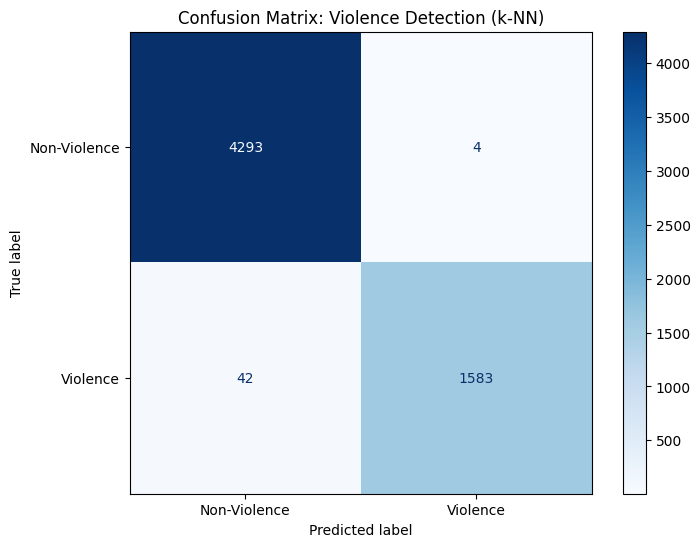

In [63]:
fig, ax = plt.subplots(figsize=(8,6))
ConfusionMatrixDisplay.from_estimator(
    knn_pipeline, X_test, y_test,
    display_labels=["Non-Violence","Violence"],
    cmap=plt.cm.Blues, ax=ax
)
plt.title("Confusion Matrix: Violence Detection (k-NN)")
plt.show()

In [64]:
def predict_audio_file_knn(file_path, threshold=0.5):
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, mono=True)
    segment_probs = []
    for seg in split_audio(audio):
        mfcc = extract_mfcc(seg)
        if mfcc is None:
            continue
        prob = knn_pipeline.predict_proba([mfcc])[0][1]
        segment_probs.append(prob)
    if not segment_probs:
        return "Non-Violence", [0.0,1.0]
    avg_prob = np.mean(segment_probs)
    label = "Violence" if avg_prob > threshold else "Non-Violence"
    return label, [1-avg_prob, avg_prob]

file_path = "/content/drive/MyDrive/test4.wav"
label, prob = predict_audio_file_knn(file_path)
print(file_path, "->", label, "Probabilities:", prob)


/content/drive/MyDrive/test4.wav -> Violence Probabilities: [np.float64(0.2024838871805692), np.float64(0.7975161128194308)]


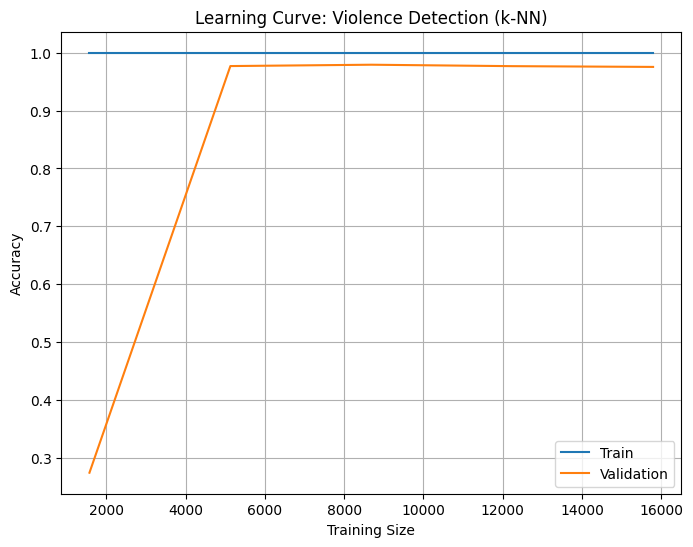

In [65]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    knn_pipeline,
    X,
    y,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, label='Train')
plt.plot(train_sizes, test_mean, label='Validation')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve: Violence Detection (k-NN)')
plt.legend()
plt.grid(True)
plt.show()


In [49]:
# Save the trained k-NN pipeline
model_path = "/content/drive/MyDrive/violence_knn_model.pkl"
joblib.dump(knn_pipeline, model_path)
print(f"Model saved to: {model_path}")


Model saved to: /content/drive/MyDrive/violence_knn_model.pkl


In [50]:
from google.colab import files

files.download(model_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>